#### Dataset/DataLoader

In [1]:
import os
import numpy as np
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
CIFAR_DIR = Path("..") / "data" / "cifar-10-batches-py"  # <- sobe um nível

dirs = [
    'data_batch_1','data_batch_2','data_batch_3',
    'data_batch_4','data_batch_5','test_batch','batches.meta'
]

def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')


all_data = []
for direc in dirs:
    path = CIFAR_DIR / direc
    print(f"Lendo: {path}")
    all_data.append(unpickle(path))


Lendo: ..\data\cifar-10-batches-py\data_batch_1
Lendo: ..\data\cifar-10-batches-py\data_batch_2
Lendo: ..\data\cifar-10-batches-py\data_batch_3
Lendo: ..\data\cifar-10-batches-py\data_batch_4
Lendo: ..\data\cifar-10-batches-py\data_batch_5
Lendo: ..\data\cifar-10-batches-py\test_batch
Lendo: ..\data\cifar-10-batches-py\batches.meta


In [4]:
# all_data = [data_batch_1,..., data_batch_5, test_batch, batches.meta]
train_batches = all_data[:5]
test_batch = all_data[5]
meta = all_data[6]

In [5]:
label_names = meta[b'label_names'] if b'label_names' in meta else meta['label_names']
label_names = [ln.decode('utf-8') if isinstance(ln, bytes) else ln for ln in label_names]

print(label_names) 

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Lotes de treino e teste (X, y)

In [6]:
def uget(d, key):
    """Acessa chave tratando bytes/str."""
    return d.get(key, d.get(key.encode()))

In [7]:
# Empilha dados de treino
X_tr_list = [uget(b, 'data') for b in train_batches]         # listas de arrays (10000 x 3072)
y_tr_list = [uget(b, 'labels') for b in train_batches]       # listas de listas (10000,)

X_train = np.concatenate(X_tr_list, axis=0)                  # (50000, 3072)
y_train = np.array(sum(y_tr_list, []), dtype=np.int64)       # (50000,)

# Teste
X_test = uget(test_batch, 'data')                            # (10000, 3072)
y_test = np.array(uget(test_batch, 'labels'), dtype=np.int64)# (10000,)

print(f'X_train: {X_train.shape} \ny_train: {y_train.shape}\n\nX_test: {X_test.shape}\ny_test: {y_test.shape}')


X_train: (50000, 3072) 
y_train: (50000,)

X_test: (10000, 3072)
y_test: (10000,)


#### Converção para imagens e normalização

In [8]:
def to_images(x_flat):
    x = x_flat.reshape(-1, 3, 32, 32)           # (N, 3, 32, 32)
    x = np.transpose(x, (0, 2, 3, 1))           # (N, 32, 32, 3)
    return x

X_train = to_images(X_train)
X_test  = to_images(X_test)

# Normalização simples [0,1] — depois podemos padronizar por canal
X_train = (X_train / 255.0).astype(np.float32)
X_test  = (X_test  / 255.0).astype(np.float32)

print("Train min/max:", X_train.min(), X_train.max())

Train min/max: 0.0 1.0


#### Conjunto de Validação

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=5000, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}\n Val: {X_val.shape} \n Test: {X_test.shape}")

Train: (45000, 32, 32, 3)
 Val: (5000, 32, 32, 3) 
 Test: (10000, 32, 32, 3)


In [10]:
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u} - {label_names[u]:12s}: {c}")


0 - airplane    : 4500
1 - automobile  : 4500
2 - bird        : 4500
3 - cat         : 4500
4 - deer        : 4500
5 - dog         : 4500
6 - frog        : 4500
7 - horse       : 4500
8 - ship        : 4500
9 - truck       : 4500


#### Display Some Examples

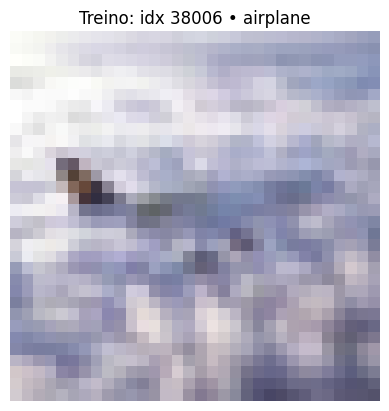

In [11]:
def show_example(X, y, idx=None, title_prefix=""):
    if idx is None:
        idx = random.randrange(len(X))
    plt.imshow(X[idx])
    plt.axis('off')
    lbl = label_names[y[idx]]
    plt.title(f"{title_prefix}idx {idx} • {lbl}")
    plt.show()

# Exemplo único do conjunto de treino
show_example(X_train, y_train, title_prefix="Treino: ")

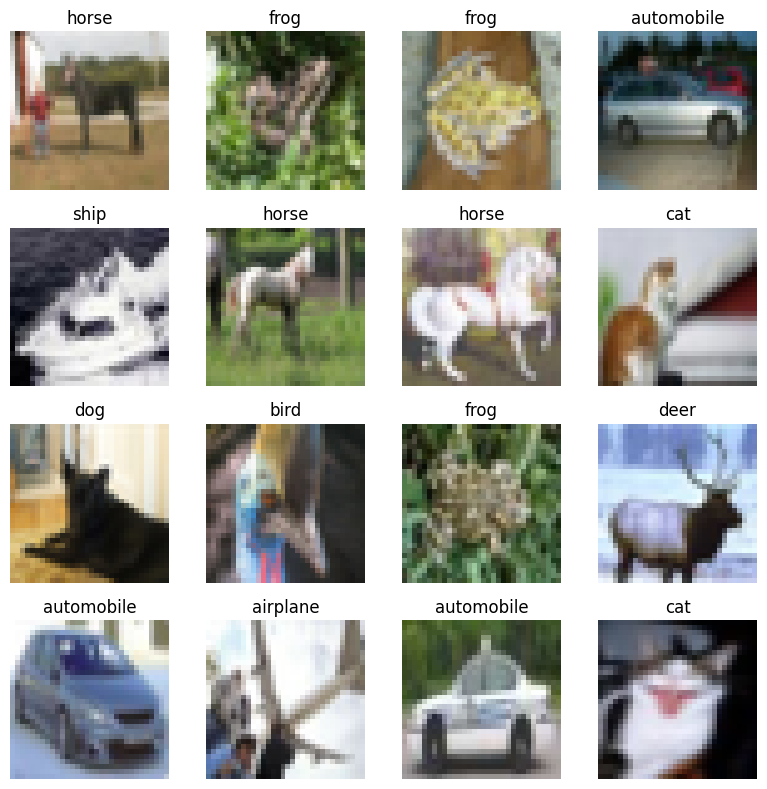

In [12]:
def show_grid(X, y, rows=4, cols=4):
    plt.figure(figsize=(cols*2, rows*2))
    idxs = random.sample(range(len(X)), rows*cols)
    for i, idx in enumerate(idxs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(X[idx])
        plt.axis('off')
        plt.title(label_names[y[idx]])
    plt.tight_layout()
    plt.show()

show_grid(X_train, y_train, rows=4, cols=4)
